### ПРИМЕР РАСПОЗНАВАНИЯ НОМЕРА ПАСПОРТА, КОГДА ЦИФРЫ СДЕЛАНЫ ПЕРФОРАЦИЕЙ.
ОСНОВНАЯ СЛОЖНОСТЬ В ОСТУТСТВИИ ЗАМКНУТОГО КОНТУРА ЦИФР

Данильченко Вадим

In [133]:
# импортируем библиотеки

import os
import re, joblib
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from pytesseract import image_to_string, image_to_boxes
import easyocr

import imutils
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [134]:
# объявим функции


def extract_tesseract(img):
    """
    функция экстрактит текст с помощью pytesseract
    """
    result = image_to_string(img, config='digits --oem 3 --psm 6 tessedit_char_whitelist=0123456789')
    if not result:
        print('pytesseract: found nothing')
        result = None
    else:
        print('pytesseract:', result)
    return result

def extract_easyocr(img):
    """
    функция экстрактит текст с помощью easyocr
    """
    reader = easyocr.Reader(['ru']) # need to run only once to load model into memory
    result = reader.readtext(img, allowlist='0123456789')
    if result:
        result = result[0][-2:]
        print('easyOcr:', result)
    else:
        print('easyOcr: found nothing')
        result = None
    
    return result

        
def extract_text(img):
    """
    функция сравнивает результаты работы pytesseract и easyocr
    """
    
    THRESHOLD = 0.85
    
    tesser = extract_tesseract(img)
    easy = extract_easyocr(img)
    
    if easy:
        if easy[-1]>=THRESHOLD:
            return '\nрезультат' + str(easy)
        elif tesser:
            if len(tesser)>=len(easy):
                return '\nрезультат' + str(tesser)
            else:
                return '\nрезультат: ' + str(easy)
        else:
            return '\nрезультат: nothing found'
            

def threshold(gray_scale, nz_part=0.3):
    """
    функция помогает найти оптимальный трешолд для бинаризации изображения на основе доли белых пикселей
    """
    maxval = 255
    nonzero_percent = 1
    while nonzero_percent > nz_part: # and maxval > 150:
        _, thresh_value = cv2.threshold(gray_scale, maxval, 255, cv2.THRESH_BINARY_INV)
        nonzero_percent = np.count_nonzero(thresh_value) / \
                          (thresh_value.shape[0] * thresh_value.shape[1])
        maxval -= 1
    return thresh_value



def inverse_color(img):
    """
    инвертирует бинаризованное изображение
    :param img: изображение
    """
    return cv2.bitwise_not(img)


def cut_coordinates(image, filename):
    """
    функция подтягивает область паспорта из разметки и вырезает по кооординатам
    :param image:
    :param filename:
    :return:
    """
    coordinates = region_path + filename.split('.')[0] + '.txt'
    if not os.path.isfile(coordinates):
        raise FileNotFoundError(f'file {coordinates} was not found')

    with open(coordinates, 'r') as f:
        cut_region = f.read().splitlines()

    dh, dw, _ = np.asarray(image).shape
    data = [float(_) for _ in cut_region[0].split(' ')]
    _, x_start, y_start, w_start, h_start = data
    minX = int((x_start - w_start / 2) * dw)  # left
    maxX = int((x_start + w_start / 2) * dw)  # right
    minY = int((y_start - h_start / 2) * dh)  # top
    maxY = int((y_start + h_start / 2) * dh)  # bottom

    if minX < 0:
        minX = 0
    if maxX > dw - 1:
        maxX = dw - 1
    if minY < 0:
        minY = 0
    if maxY > dh - 1:
        maxY = dh - 1

        # print('minX = ',minX, '    minY = ', minY, '    maxX = ', maxX, '    maxY = ',maxY, sep='') # Выводим полученные значения
        # return [minX, minY, maxX, maxY]
    return np.asarray(image)[minY:maxY, minX: maxX]


def rotate_img(image, filename):
    """
    функция поворачивает изображение в соответствии с разметкой
    :param img:
    :return:
    """
    angle = np.nan
    data = pd.read_excel('./img-angle.xlsx')
    angle = data[data['img']==filename]['angle'].values[0]
    if angle!=angle:
        raise ValueError(f'angle for file {filename} was not found')

    # rows = image.shape[0]
    # cols = image.shape[1]

    # img_center = (cols / 2, rows / 2)
    # M = cv2.getRotationMatrix2D(img_center, angle, 1)
    # return cv2.warpAffine(image, M, (rows, cols),
    #                       borderMode=cv2.BORDER_CONSTANT,
    #                       borderValue=(255, 255, 255))
    return imutils.rotate_bound(image, -angle)


def show_boxes(img):
    """
    функция отображает области цифр, найденные pytesseract
    """
    img = img.copy()
    boxes = image_to_boxes(img, config='digits --oem 3 --psm 6 tessedit_char_whitelist=0123456789')
    print(boxes)

    for b in boxes.splitlines():
        b = b.split(' ')
        print(b)
        x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
        cv2.rectangle(img, (x, img.shape[0] - y), (w, img.shape[0] - h), (0, 0, 255), 3)

    plt.imshow(img)

In [135]:
# откроем изображение
img_path = './passport_reg/'
region_path = './coordinates/'
filename = '0108288590.jpg'

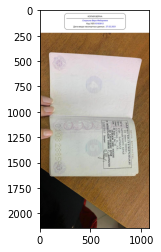

In [136]:
img = Image.open(img_path + filename)
plt.imshow(img)

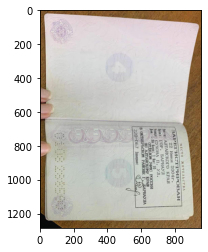

In [137]:
# обрежем по контуру паспорта
# img_cut = np.asarray(img)[500:700, 450:720]#[615:655, 460:680]
try:
    img_cut = cut_coordinates(img, filename)
    plt.imshow(img_cut)
    # plt.waitforbuttonpress(-1)
except:
    # continue
    pass

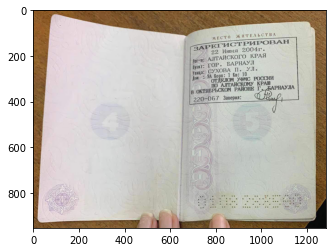

In [138]:

# повернем изображение
try:
    img_cut = rotate_img(img_cut, filename)
    plt.imshow(img_cut)
    # plt.waitforbuttonpress(-1)
except:
    # continue
    pass

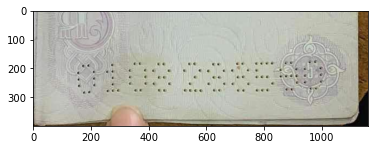

In [139]:
# масштабируем изображение, чтобы всегда иметь одну высоту
img_resized = imutils.resize(img_cut, height=1800)

# обрежем на половину горизонтально и вертикально
y = img_resized.shape[0]//2
x = img_resized.shape[1]//2
offset = 50
# plt.imshow(img_cut[y + y // 2:img_cut.shape[0]-offset, x:img_cut.shape[1] - offset])
# plt.waitforbuttonpress(-1)

img_cut =  img_resized[y+y//2:img_resized.shape[0]-offset, x:img_resized.shape[1]-offset]
plt.imshow(img_cut)

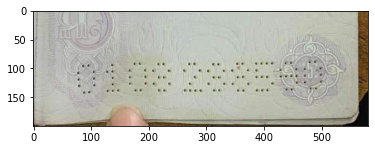

In [140]:
# масштабируем до высоты 200
img_cut = imutils.resize(img_cut, height=200)
plt.imshow(img_cut)

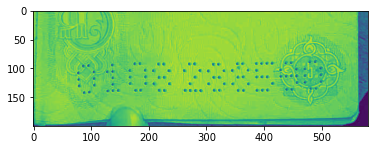

In [141]:
# ковертируем в оттенки серого
if img.mode=='RGB':
    img_gray = cv2.cvtColor(img_cut, cv2.COLOR_RGB2GRAY)
elif img.mode=='BGR':
    img_gray = cv2.cvtColor(img_cut, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)

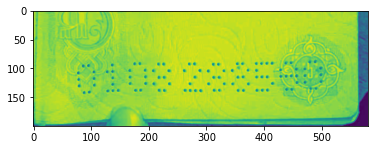

In [142]:
####################### попробуем adaptive threshold to improve thresholding using nearest neighbours

# немного размоем изображение
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
plt.imshow(img_blur)

поиграем с гиперпараметрами при подборе трешолда для бинаризации 

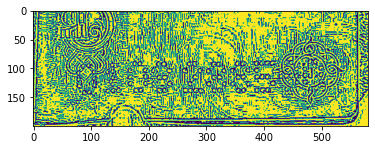

In [143]:
thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 3, 0) # делает более жирными контуры
plt.imshow(thresh)

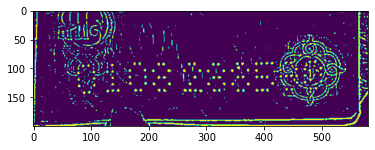

In [144]:
thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 7) # делает более жирными контуры
plt.imshow(thresh)

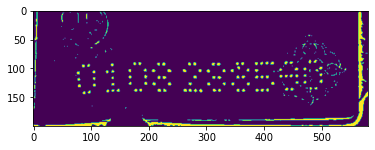

In [145]:
thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 18) # делает более жирными контуры
plt.imshow(thresh)

оставляем, остальной шум уберем с помощью морфологических преобразований

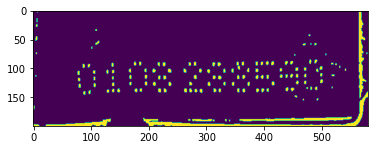

In [146]:
erode = cv2.erode(thresh, np.ones((1,3)), iterations=1)
erode = cv2.dilate(erode, np.ones((3,2)), iterations=1)
# dilate = cv2.dilate(erode, np.ones((3,3)), iterations=2)
# erode = cv2.erode(dilate, np.ones((3,3)), iterations=1)
plt.imshow(erode)

начнем поочередно выполнять замыкание контура
1. вертикально
2. горизонтально
3. диагонально снизу-вверх
4. диагонально сверху-вниз

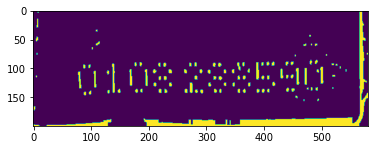

In [147]:
# 1. вертикально
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 10))
gradX = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, rectKernel)
plt.imshow(gradX)

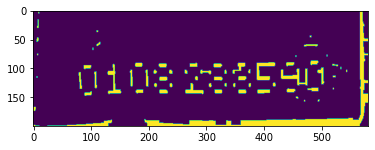

In [148]:
# 2. горизонтально
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 2))
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
plt.imshow(gradX)

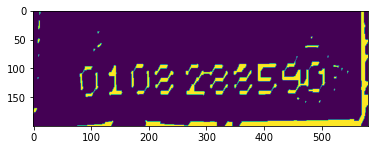

In [149]:
# 3. диагонально снизу-вверх
diagKernel = np.array([[0,0,1,1],
                        [0,0,1,1],
                        [0,1,1,1],
                        [0,1,1,0],
                        # [0,1,1,0],
                        # [1,1,1,0],
                        # [0,1,1,1,0],
                        [1,1,0,0],
                        [1,1,0,0]], dtype='uint8')
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, diagKernel, iterations=2)
plt.imshow(gradX)

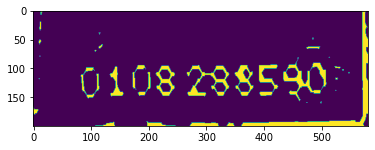

In [150]:
# 4. диагонально сверху-вниз
diagKernel = np.array([[1,1,0,0],
                        [1,1,0,0],
                        [1,1,1,0],
                        [0,1,1,0],
                        # [0,1,1,0],
                        # [0,1,1,0],
                        # [0,1,1,1],
                        [0,0,1,1],
                        [0,0,1,1]], dtype='uint8')

gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, diagKernel, iterations=2)
plt.imshow(gradX)

In [151]:
# # немного размоем 
# gradX = cv2.erode(gradX, np.ones((2,2)), iterations=1)
# plt.imshow(gradX)

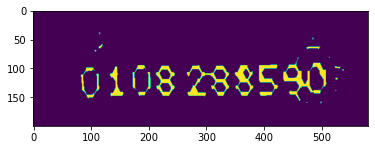

In [152]:
# избавляемся от ненужных пикселей по углам изображения (границы паспорта)

def drop_contours(img, coef = 0.1):
    # удалим пиксели по краям изображения
    p = int(img.shape[1] * coef)
    img[:, 0:p] = 0
    img[:, img.shape[1] - p:] = 0
    # plt.imshow(thresh)

    # повторим для y
    p = int(img.shape[0] * coef)
    img[0:p, :] = 0
    img[img.shape[0] - p:, :] = 0
    # plt.imshow(img)
    return img

thresh = drop_contours(gradX, 0.07)
plt.imshow(thresh)

In [153]:
print(extract_text(inverse_color(thresh)))

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


pytesseract: 0108288590

easyOcr: ('0108288590', 0.8794486320160461)

результат('0108288590', 0.8794486320160461)
